In [1]:
import sys, os

sys.path.append(os.path.abspath(
    os.getcwd()+"/src")
)

In [2]:
from src.data_management import deformation_from_name
from src.data_gen import deformation_to_image_mapper
from src.benchmark import benchmark_nn_decoder

from qecsim.models.rotatedplanar import RotatedPlanarCode
from qecsim.models.generic import BiasedDepolarizingErrorModel

import json
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

key = random.key(0)

In [4]:
model_dir = "../results"
model_names = os.listdir(model_dir)
batch_size = 100_000 # Can not be too large due to memory constraints (especially for large codes) for more batches use multiple runs with repeats > 1
repeats = 100 # Number of times to repeat the whole batch to get more statistics
error_probabilities = jnp.array(BiasedDepolarizingErrorModel(
    bias=500,
    axis="Z"
).probability_distribution(0.01))
OVERWRITE_EXISTING = True # Whether to overwrite existing benchmark results without asking

for model_name in model_names:
    with open(f"{model_dir}/{model_name}/settings.json", "r") as f:
        deformation_name = json.load(f)["<deformation_name>"]
    if deformation_name not in ["CSS", "XZZX", "XY", "C1"]:
        continue # Only benchmark models trained on a specific deformation
    if os.path.exists(f"{model_dir}/{model_name}/benchmark.json") and not OVERWRITE_EXISTING:
        answer = ""
        while answer.lower() not in ("y", "n"):
            answer = input(f"A benchmark result for model {model_name} already exists. Overwrite? (y/n) ")
        if answer.lower() == "n":
            print(f"Skipping model {model_name}")
            continue
        else:
            print(f"Overwriting existing benchmark result for model {model_name}")
    else:
        print(f"Benchmarking model {model_name}")
    # Use the same base key for all models so they are benchmarked on the same errors
    base_key = random.key(0)
    lers = []
    hist2d = jnp.zeros((4,4), dtype=jnp.int32)
    print("Progress: ["+100*" "+"]", end="\r")
    for i, key in enumerate(random.split(base_key, repeats)): # Repeat the benchmark multiple times to get more statistics
        ler, hist2d_next = benchmark_nn_decoder(
            key,
            batch_size,
            model_name,
            error_probabilities=error_probabilities, 
            with_histogram_2d=True
        )
        lers.append(ler)
        hist2d = hist2d + hist2d_next
        progress = int(jnp.round((i+1)/repeats*100))
        print("Progress: ["+"#"*progress+" "*(100-progress)+f"] {((i+1)/repeats):7.2%}", end="\r")
    print() # New line after progress bar
    ler = jnp.mean(jnp.array(lers))
    # Save results
    result = {
        "hist2d": hist2d.tolist(),
        "error_probabilities": error_probabilities.tolist(),
        "batch_size": batch_size,
        "repeats": repeats,
        "ler": float(ler)
    }
    with open(f"{model_dir}/{model_name}/benchmark.json", "w") as f:
        json.dump(result, f, indent=4)
    print(f"Model: {model_name}, LER: {ler:.5%}")
    print(150*"-")

Benchmarking model C1_d7_100K
Progress: [####################################################################################################] 100.00%
Model: C1_d7_100K, LER: 0.07913%
------------------------------------------------------------------------------------------------------------------------------------------------------
Benchmarking model XZZX_d5_1M
Progress: [####################################################################################################] 100.00%
Model: XZZX_d5_1M, LER: 0.00667%
------------------------------------------------------------------------------------------------------------------------------------------------------
Benchmarking model XZZX_d3_10K
Progress: [####################################################################################################] 100.00%
Model: XZZX_d3_10K, LER: 0.03997%
------------------------------------------------------------------------------------------------------------------------------------------------

Logical error rate is 0.01% under a physical error rate of 1.00%


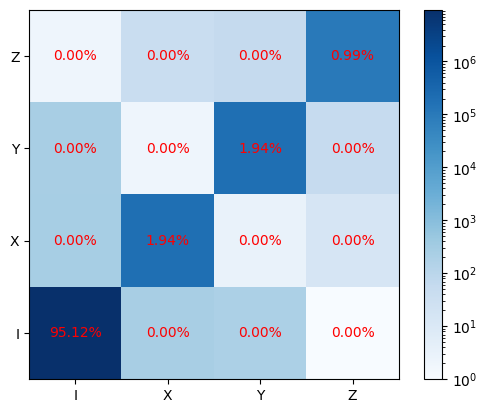

In [14]:
model_name = "XY_d3_10M"

with open(f"{model_dir}/{model_name}/benchmark.json", "r") as f:
    result = json.load(f)

hist2d = jnp.array(result["hist2d"])
error_probabilities = jnp.array(result["error_probabilities"])
batch_size = result["batch_size"]
repeats = result["repeats"]
ler = result["ler"]

print(f"Logical error rate is {ler:.2%} under a physical error rate of {error_probabilities[1:].sum():.2%}")

plt.figure()
plt.imshow(hist2d, cmap='Blues', interpolation='nearest', norm='log')
for i in range(4):
    for j in range(4):
        plt.text(j, i, f"{hist2d[i, j] / batch_size / repeats :.2%}", ha='center', va='center', color='red')
plt.colorbar()
plt.gca().invert_yaxis()
plt.yticks(range(4), ['I', 'X', 'Y', 'Z'])
plt.xticks(range(4), ['I', 'X', 'Y', 'Z'])
plt.show()